130


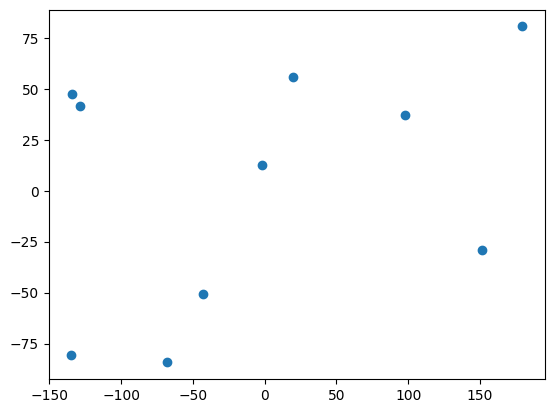

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import string

sd = np.random.randint(0, 10000)
print(sd)
np.random.seed(sd)  # 312

# ==================== 数据准备 ====================
# x = [116.46, 117.2, 121.48, 106.54, 91.11, 87.98, 106.27, 111.65, 108.33, 126.63]
# y = [39.92, 39.13, 31.22, 29.59, 29.97, 43.77, 38.47, 40.82, 22.84, 45.75]
# dist = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J'}

NUM_CITYS = 10

# 随机生成70个城市的坐标 (x: 经度, y: 纬度)
x = [np.random.uniform(-180, 180) for _ in range(NUM_CITYS)]  # 经度范围 -180 到 180
y = [np.random.uniform(-90, 90)   for _ in range(NUM_CITYS)]  # 纬度范围 -90 到 90

# 生成城市名称映射，使用字母 A-Z 和 AA-ZZ 的组合
def generate_city_labels(n):
    labels = []
    for i in range(n):
        if i < 26:
            labels.append(string.ascii_uppercase[i])
        else:
            labels.append(string.ascii_uppercase[i // 26 - 1] + string.ascii_uppercase[i % 26])
    return labels

dist = {i: label for i, label in enumerate(generate_city_labels(NUM_CITYS))}

# 计算距离矩阵
num_cities = len(x)
DIS = np.zeros((num_cities, num_cities))
for i in range(num_cities):
    for j in range(num_cities):
        DIS[i,j] = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2)

plt.scatter(x, y)
plt.show()

In [2]:
# ==================== 改进的贪心算法 ====================
def greedy_tsp(distances, num_solutions=20, k=5):
    """
    改进的贪心算法，从最近的k个城市中随机选择下一个城市
    :param distances: 距离矩阵
    :param num_solutions: 生成解的数量
    :param k: 从最近的k个城市中随机选择
    :return: 生成的解列表
    """
    n = len(distances)
    solutions = []
    for _ in range(num_solutions):
        start_city = np.random.randint(n)
        path = [start_city]
        unvisited = set(range(n)) - {start_city}
        while unvisited:
            last = path[-1]
            # 获取所有未访问城市及其距离
            candidates = [(city, distances[last, city]) for city in unvisited]
            # 按距离排序
            candidates.sort(key=lambda x: x[1])
            # 选择前k个最近的（如果存在k个）
            k_nearest = min(k, len(candidates))
            # 随机选择一个
            next_city = candidates[np.random.randint(0, k_nearest)][0]
            path.append(next_city)
            unvisited.remove(next_city)
        solutions.append(path)
    return solutions


In [3]:
# ==================== 蚁群算法实现 ====================
class ACO_TSP:
    def __init__(self, distances, num_ants=200, max_iter=50, alpha=1, beta=3, rho=0.1, Q=1):
        self.distances = distances
        self.num_ants = num_ants
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        self.n = len(distances)
        self.pheromone = np.ones((self.n, self.n)) * 0.1
        self.best_path = None
        self.best_length = float('inf')
        self.frames = []
    
    def run(self):
        for _ in range(self.max_iter):
            all_paths = []
            for _ in range(self.num_ants):
                path = self.build_path()
                all_paths.append(path)
            self.update_pheromone(all_paths)
            self.record_frame(all_paths)
    
    def build_path(self):
        path = [0]
        unvisited = set(range(1, self.n))
        while unvisited:
            current = path[-1]
            probs = []
            for city in unvisited:
                phe = self.pheromone[current][city] ** self.alpha
                vis = (1/(self.distances[current][city]+1e-10)) ** self.beta
                probs.append(phe * vis)
            probs = np.array(probs) / sum(probs)
            next_city = np.random.choice(list(unvisited), p=probs)
            path.append(next_city)
            unvisited.remove(next_city)
        return path
    
    def update_pheromone(self, all_paths):
        self.pheromone *= (1 - self.rho)
        for path in all_paths:
            length = self.calc_path_length(path)
            delta = self.Q / length
            for i in range(len(path)-1):
                self.pheromone[path[i], path[i+1]] += delta
            self.pheromone[path[-1], path[0]] += delta
            if length < self.best_length:
                self.best_length = length
                self.best_path = path + [path[0]]
    
    def calc_path_length(self, path):
        return sum(self.distances[path[i], path[i+1]] for i in range(len(path)-1)) \
               + self.distances[path[-1], path[0]]
    
    def record_frame(self, all_paths):
        current_path = all_paths[0] + [all_paths[0][0]]
        x_curr = [x[i] for i in current_path]
        y_curr = [y[i] for i in current_path]
        x_best = [x[i] for i in self.best_path]
        y_best = [y[i] for i in self.best_path]
        self.frames.append(('ACO', x_curr, y_curr, x_best, y_best, self.best_length))

In [4]:
import numpy as np

class PSO_TSP:
    def __init__(self, distances, num_particles=500, max_iter=200, w=0.8, c1=1.5, c2=1.5, greedy_solutions=0.8):
        self.distances = distances
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.n = len(distances)
        self.gbest_path = None
        self.gbest_length = float('inf')
        self.frames = []
        
        # 初始化粒子（保持原始实现不变）
        greedy_solutions = self._generate_greedy_solutions(int(num_particles*greedy_solutions))
        self.particles = []
        for i in range(num_particles):
            if i < len(greedy_solutions):
                path = greedy_solutions[i]
            else:
                path = np.random.permutation(self.n).tolist()
            velocity = 0
            pbest_path = path.copy()
            pbest_length = self._calc_path_length(path)
            if pbest_length < self.gbest_length:
                self.gbest_length = pbest_length
                self.gbest_path = path.copy()
            self.particles.append({
                'path': path,
                'velocity': velocity,
                'pbest_path': pbest_path,
                'pbest_length': pbest_length
            })
    
    def _generate_greedy_solutions(self, num_solutions):
        """原始贪心解生成（保持原样）"""
        solutions = []
        for _ in range(num_solutions):
            start = np.random.randint(self.n)
            path = [start]
            unvisited = set(range(self.n)) - {start}
            while unvisited:
                last = path[-1]
                next_city = min(unvisited, key=lambda x: self.distances[last][x])
                path.append(next_city)
                unvisited.remove(next_city)
            solutions.append(path)
        return solutions
    
    def run(self):
        """仅添加2-opt优化的主循环"""
        for _ in range(self.max_iter):
            for p in self.particles:
                # 保持原始速度更新逻辑
                v_pbest = self._path_difference(p['path'], p['pbest_path'])
                v_gbest = self._path_difference(p['path'], self.gbest_path)
                new_velocity = self.w * p['velocity'] + self.c1 * np.random.rand() * v_pbest + self.c2 * np.random.rand() * v_gbest
                new_velocity = np.clip(new_velocity, 0, self.n//2)
                
                # 保持原始路径更新
                new_path = self._apply_velocity(p['path'], new_velocity)
                
                # >>> 唯一新增部分：在更新后应用2-opt <<<
                new_path = self._two_opt(new_path)
                # >>> 结束新增部分 <<<
                
                new_length = self._calc_path_length(new_path)
                
                # 保持原始最优解更新逻辑
                if new_length < p['pbest_length']:
                    p['pbest_path'] = new_path.copy()
                    p['pbest_length'] = new_length
                    if new_length < self.gbest_length:
                        self.gbest_length = new_length
                        self.gbest_path = new_path.copy()
                p['path'] = new_path
                p['velocity'] = new_velocity
            
            self._record_frame()
    
    def _two_opt(self, path):
        """纯2-opt实现（无其他优化）"""
        best_path = path.copy()
        best_length = self._calc_path_length(path)
        n = self.n
        improved = True
        while improved:
            improved = False
            for i in range(n - 1):
                for j in range(i + 2, n):
                    if j == n and i == 0:
                        continue
                    # 计算交换后的长度变化
                    delta = (self.distances[best_path[i]][best_path[j]] + 
                            self.distances[best_path[i+1]][best_path[(j+1)%n]] -
                            self.distances[best_path[i]][best_path[i+1]] - 
                            self.distances[best_path[j]][best_path[(j+1)%n]])
                    if delta < -1e-6:  # 有改进
                        best_path[i+1:j+1] = best_path[j:i:-1]
                        best_length += delta
                        improved = True
        return best_path
    
    # 以下保持原始实现完全不变
    def _path_difference(self, path1, path2):
        swap_count = 0
        temp = path1.copy()
        for i in range(self.n):
            if temp[i] != path2[i]:
                j = temp.index(path2[i])
                temp[i], temp[j] = temp[j], temp[i]
                swap_count += 1
        return swap_count
    
    def _apply_velocity(self, path, velocity):
        new_path = path.copy()
        swap_times = int(abs(velocity))
        for _ in range(swap_times):
            i, j = np.random.choice(self.n, 2, replace=False)
            new_path[i], new_path[j] = new_path[j], new_path[i]
        return new_path
    
    def _calc_path_length(self, path):
        return sum(self.distances[path[i]][path[i+1]] for i in range(self.n-1)) + self.distances[path[-1]][path[0]]
    
    def _record_frame(self):
        current_path = self.particles[0]['path'] + [self.particles[0]['path'][0]]
        x_curr = [x[i] for i in current_path] if 'x' in globals() else []
        y_curr = [y[i] for i in current_path] if 'y' in globals() else []
        x_best = [x[i] for i in self.gbest_path] + [x[self.gbest_path[0]]] if self.gbest_path else []
        y_best = [y[i] for i in self.gbest_path] + [y[self.gbest_path[0]]] if self.gbest_path else []
        self.frames.append(('PSO', x_curr, y_curr, x_best, y_best, self.gbest_length))

In [5]:
import numpy as np
from typing import List, Tuple

class GA_TSP:
    def __init__(self, 
                 distances: np.ndarray, 
                 pop_size: int = 500, 
                 max_iter: int = 200, 
                 pc: float = 0.8, 
                 pm: float = 0.05, 
                 greedy_ratio: float = 0.3,
                 use_2opt: bool = True,
                 adaptive_params: bool = True):
        """
        改进的遗传算法求解TSP问题
        
        参数:
            distances: 距离矩阵 (n x n)
            pop_size: 种群规模
            max_iter: 最大迭代次数
            pc: 交叉概率 (0-1)
            pm: 变异概率 (0-1)
            greedy_ratio: 初始种群中贪心解的比例
            use_2opt: 是否启用2-opt局部优化
            adaptive_params: 是否启用自适应参数
        """
        self.distances = distances
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.pc = pc
        self.pm = pm
        self.n = len(distances)
        self.best_path = None
        self.best_length = float('inf')
        self.frames = []
        self.use_2opt = use_2opt
        self.adaptive_params = adaptive_params
        
        # 初始化种群 (混合贪心解和随机解)
        self.population = self._initialize_population(greedy_ratio)
        
        # 自适应参数记录
        self.avg_fitness_history = []
    
    def _initialize_population(self, greedy_ratio: float) -> List[List[int]]:
        """初始化种群，包含贪心解和随机解"""
        population = []
        
        # 加入贪心解 (最近邻算法)
        num_greedy = int(self.pop_size * greedy_ratio)
        for _ in range(num_greedy):
            start_city = np.random.randint(self.n)
            path = [start_city]
            unvisited = set(range(self.n)) - {start_city}
            
            while unvisited:
                last = path[-1]
                next_city = min(unvisited, key=lambda x: self.distances[last][x])
                path.append(next_city)
                unvisited.remove(next_city)
            
            population.append(path)
        
        # 加入随机解
        while len(population) < self.pop_size:
            population.append(np.random.permutation(self.n).tolist())
        
        return population
    
    def run(self) -> Tuple[List[int], float]:
        """运行遗传算法主循环"""
        for iteration in range(self.max_iter):
            # 自适应参数调整
            if self.adaptive_params:
                self._adjust_parameters(iteration)
            
            # 评估适应度
            fitness = [1 / self._calc_path_length(p) for p in self.population]
            self.avg_fitness_history.append(np.mean(fitness))
            
            # 更新最优解
            current_best_idx = np.argmax(fitness)
            current_best_length = self._calc_path_length(self.population[current_best_idx])
            if current_best_length < self.best_length:
                self.best_length = current_best_length
                self.best_path = self.population[current_best_idx].copy()
            
            # 选择 (锦标赛选择)
            selected = self._tournament_selection(fitness)
            
            # 交叉 (顺序交叉OX)
            offspring = []
            for i in range(0, len(selected), 2):
                if i + 1 < len(selected):
                    child1, child2 = self._ox_crossover(selected[i], selected[i+1])
                    offspring.extend([child1, child2])
            
            # 变异 (交换变异+2-opt)
            offspring = [self._enhanced_mutation(ind) for ind in offspring]
            
            # 精英保留策略
            offspring = self._apply_elitism(offspring)
            
            # 更新种群
            self.population = offspring[:self.pop_size]
            
            # 记录当前状态 (用于可视化)
            self._record_frame()
        
        return self.best_path, self.best_length
    
    def _adjust_parameters(self, iteration: int):
        """自适应调整交叉和变异概率"""
        # 随着迭代增加降低变异概率
        progress = iteration / self.max_iter
        self.pm = max(0.01, self.pm * (1 - progress * 0.8))
        
        # 如果种群多样性下降，增加变异概率
        if len(self.avg_fitness_history) > 10:
            last_improvement = abs(self.avg_fitness_history[-1] - self.avg_fitness_history[-10])
            if last_improvement < 1e-5:
                self.pm = min(0.3, self.pm * 1.5)
    
    def _tournament_selection(self, fitness: List[float], k: int = 3) -> List[List[int]]:
        """锦标赛选择"""
        selected = []
        for _ in range(len(self.population)):
            candidates = np.random.choice(len(self.population), k)
            winner = max(candidates, key=lambda x: fitness[x])
            selected.append(self.population[winner].copy())
        return selected
    
    def _ox_crossover(self, parent1: List[int], parent2: List[int]) -> Tuple[List[int], List[int]]:
        """顺序交叉(OX)"""
        if np.random.rand() > self.pc:
            return parent1.copy(), parent2.copy()
        
        size = len(parent1)
        cx1, cx2 = sorted(np.random.choice(size, 2, replace=False))
        
        def _create_child(p1, p2):
            child = [None] * size
            child[cx1:cx2] = p1[cx1:cx2]
            
            # 从p2填充剩余位置
            ptr = cx2 % size
            for gene in p2[cx2:] + p2[:cx2]:
                if gene not in child[cx1:cx2]:
                    child[ptr] = gene
                    ptr = (ptr + 1) % size
            return child
        
        return _create_child(parent1, parent2), _create_child(parent2, parent1)
    
    def _enhanced_mutation(self, individual: List[int]) -> List[int]:
        """增强变异操作"""
        if np.random.rand() < self.pm:
            # 交换变异
            i, j = np.random.choice(self.n, 2, replace=False)
            individual[i], individual[j] = individual[j], individual[i]
            
            # 2-opt局部优化 (概率性应用)
            if self.use_2opt and np.random.rand() < 0.3:
                individual = self._two_opt(individual)
        
        return individual
    
    def _two_opt(self, path: List[int]) -> List[int]:
        """2-opt局部优化"""
        best_path = path.copy()
        improved = True
        while improved:
            improved = False
            for i in range(1, len(path) - 1):
                for j in range(i + 1, len(path)):
                    if j - i == 1:
                        continue  # 相邻边无需交换
                    
                    # 计算交换后的距离变化
                    a, b = path[i-1], path[i]
                    c, d = path[j-1], path[j]
                    
                    current = self.distances[a][b] + self.distances[c][d]
                    new = self.distances[a][c] + self.distances[b][d]
                    
                    if new < current:
                        best_path[i:j] = best_path[j-1:i-1:-1]
                        improved = True
            path = best_path
        return best_path
    
    def _apply_elitism(self, offspring: List[List[int]], elite_ratio: float = 0.1) -> List[List[int]]:
        """精英保留策略"""
        num_elites = int(self.pop_size * elite_ratio)
        if num_elites == 0:
            return offspring
        
        # 合并父代和子代
        combined = self.population + offspring
        combined.sort(key=lambda x: self._calc_path_length(x))
        
        # 保留最优个体
        elites = combined[:num_elites]
        
        # 剩余个体从子代中随机选择
        remaining = offspring.copy()
        np.random.shuffle(remaining)
        
        return elites + remaining[:self.pop_size - num_elites]
    
    def _calc_path_length(self, path: List[int]) -> float:
        """计算路径长度"""
        return sum(self.distances[path[i]][path[i+1]] for i in range(-1, self.n-1))
    
    def _record_frame(self):
        """记录当前状态用于可视化"""
        if not self.best_path:
            return
        
        current_path = self.population[0] + [self.population[0][0]]
        best_path = self.best_path + [self.best_path[0]]
        
        # 这里假设有全局的x,y坐标 (实际使用时需要替换)
        x_curr = [x[i] for i in current_path] if 'x' in globals() else []
        y_curr = [y[i] for i in current_path] if 'y' in globals() else []
        x_best = [x[i] for i in best_path] if 'x' in globals() else []
        y_best = [y[i] for i in best_path] if 'y' in globals() else []
        
        self.frames.append(('GA', x_curr, y_curr, x_best, y_best, self.best_length))

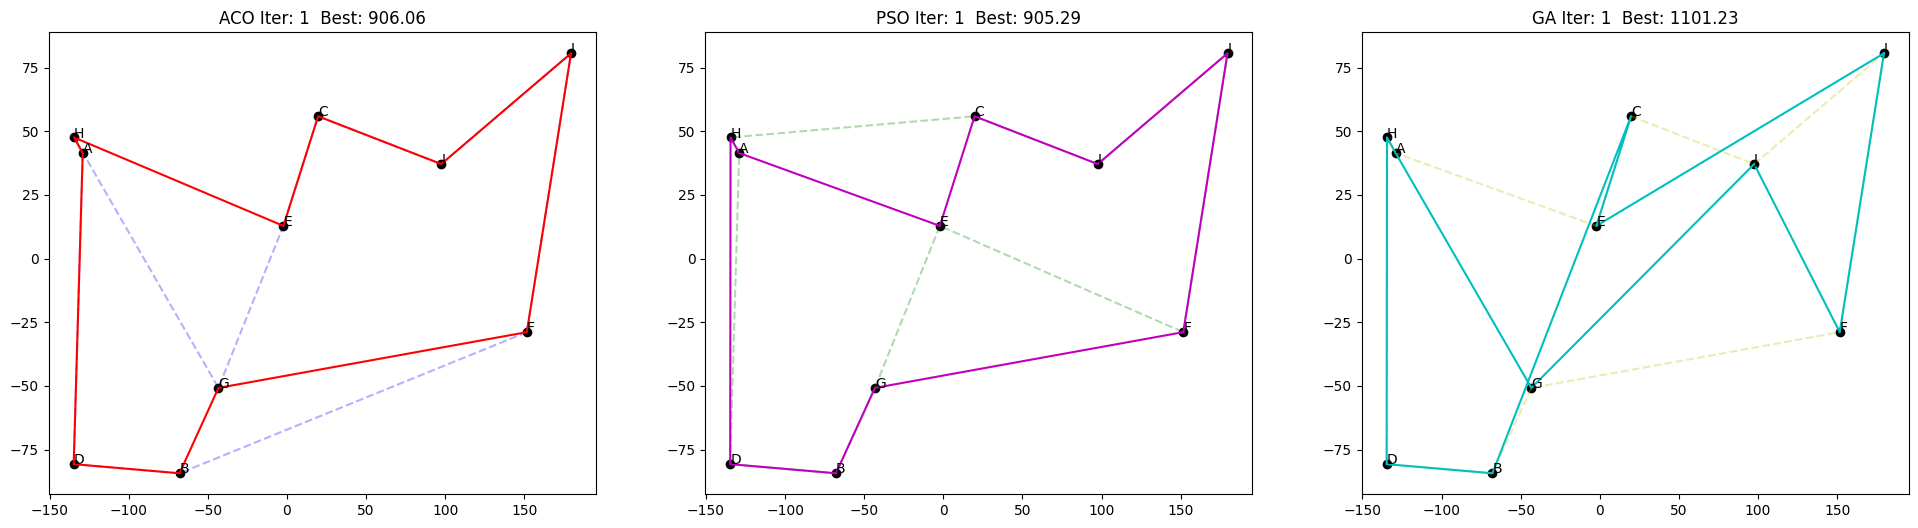

In [6]:
# ==================== 更新动画部分 ====================
# 创建画布（调整为3个子图）
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# 初始化所有算法
aco = ACO_TSP(DIS, 
              num_ants=200, 
              max_iter=50, 
              alpha=1, 
              beta=3, 
              rho=0.1, 
              Q=1)
pso = PSO_TSP(DIS,
              num_particles=200, 
              max_iter=50, 
              greedy_solutions=0)
ga = GA_TSP(DIS, 
            pop_size=100, 
            max_iter=50, 
            pc=0.5, 
            pm=0.2, 
            greedy_ratio=0)

np.random.seed(213)  # 312

# 运行所有算法
aco.run()
pso.run()
ga.run()

# 合并三个算法的帧数据
max_frames = max(len(aco.frames), len(pso.frames), len(ga.frames))
all_frames = []
for i in range(max_frames):
    aco_frame = aco.frames[i] if i < len(aco.frames) else aco.frames[-1]
    pso_frame = pso.frames[i] if i < len(pso.frames) else pso.frames[-1]
    ga_frame = ga.frames[i] if i < len(ga.frames) else ga.frames[-1]
    all_frames.append( (aco_frame, pso_frame, ga_frame) )

# 动画更新函数
def update(frame):
    aco_frame, pso_frame, ga_frame = all_frames[frame]
    
    # 更新蚁群算法视图
    ax1.clear()
    ax1.scatter(x, y, c='black')
    for i, txt in enumerate(dist.values()):
        ax1.annotate(txt, (x[i], y[i]))
    ax1.plot(aco_frame[1], aco_frame[2], 'b--', alpha=0.3)
    ax1.plot(aco_frame[3], aco_frame[4], 'r-')
    ax1.set_title(f"{aco_frame[0]} Iter: {frame+1}  Best: {aco_frame[5]:.2f}")
    
    # 更新粒子群算法视图
    ax2.clear()
    ax2.scatter(x, y, c='black')
    for i, txt in enumerate(dist.values()):
        ax2.annotate(txt, (x[i], y[i]))
    ax2.plot(pso_frame[1], pso_frame[2], 'g--', alpha=0.3)
    ax2.plot(pso_frame[3], pso_frame[4], 'm-')
    ax2.set_title(f"{pso_frame[0]} Iter: {frame+1}  Best: {pso_frame[5]:.2f}")
    
    # 更新遗传算法视图
    ax3.clear()
    ax3.scatter(x, y, c='black')
    for i, txt in enumerate(dist.values()):
        ax3.annotate(txt, (x[i], y[i]))
    ax3.plot(ga_frame[1], ga_frame[2], 'y--', alpha=0.3)
    ax3.plot(ga_frame[3], ga_frame[4], 'c-')
    ax3.set_title(f"{ga_frame[0]} Iter: {frame+1}  Best: {ga_frame[5]:.2f}")
    
    return ax1, ax2, ax3

# 创建动画
ani = FuncAnimation(fig, update, frames=len(all_frames), interval=300)

# 显示动画
# HTML(ani.to_html5_video())

ani.save(f'./assets/tsp_{NUM_CITYS}.gif', writer='pillow', fps=5)